In [1]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1317
┌ Warning: Package ReactiveMP does not have ProgressMeter in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added ProgressMeter as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading ProgressMeter into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
import ReactiveMP.messageout

In [3]:
data_seed, params_seed = 42, 120

(42, 120)

In [4]:
include("../helpers/data.jl")
include("../helpers/callbacks.jl")

In [5]:
struct DummyDistribution
end

Distributions.entropy(dist::DummyDistribution) = ReactiveMP.InfCountingReal(0.0, -1)

@marginalrule typeof(+)(:in1_in2) (m_out::PointMass, m_in1::NormalDistributionsFamily, m_in2::NormalDistributionsFamily, ) = begin 
    return DummyDistribution()
end


In [6]:
@rule Flow(:in, Marginalisation) (m_out::MultivariateNormalDistributionsFamily, m_in::MultivariateNormalDistributionsFamily, meta::FlowMeta{M,Linearization}) where { M } = begin
    # calculate outgoing message
    message_out = @call_rule Flow(:out, Marginalisation) (m_in=m_in, meta=meta)
    # calculate marginal on output
    marginal_out = prod(ProdAnalytical(), m_out, message_out)
    # propagate marginal through Flow
    marginal_in = @call_rule Flow(:in, Marginalisation) (m_out=marginal_out, meta=meta)
    # calculate upward message
    xi_m_in, W_m_in = weightedmean_precision(m_in)
    xi_q_in, W_q_in = weightedmean_precision(marginal_in)
    # return message
#     @show MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)
    return MvNormalWeightedMeanPrecision(xi_q_in - xi_m_in, W_q_in - W_m_in)  # maybe add some jitter here for stability
end

In [7]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [8]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [9]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [10]:
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [29]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, model_params, h_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    prec = 1e12
    b = ones(order)/100;
#     b = ones(order);
    params_flow = model_params[1:end-1]
    params_w    = model_params[end]
    # initialize variables
    h       = randomvar(n)
    e       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    y       = datavar(Float64, n)

    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    
    Ys = randomvar(n)
    Us = randomvar(n)

    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    
    
    S = shift(order_h);
    c = zeros(order_h); c[1] = 1.0;
    
    h[1] ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    e[1] ~ NormalMeanPrecision(0.0, melu(params_w))
    
    Ys[1] ~ MvNormalMeanPrecision(Y*y_prev[1], prec*diageye(order))
    Us[1] ~ MvNormalMeanPrecision(U*u[1], prec*diageye(order))
    hy[1] ~ H*h[1] + Ys[1]
    hyu[1] ~ hy[1] + Us[1]
#     y_lat_1[1] ~ Flow(hyu[1]) where { meta = Flow_meta }
    y_lat_1[1] ~ Flow(hyu[1]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
    y_lat_2[1] ~ dot(y_lat_1[1], b)
    y_nodes[1], y[1] ~ y_lat_2[1] + e[1]
    
    for t in 2:n
        h[t] ~ S*h[t-1] + c*e[t-1]
        e[t] ~ NormalMeanPrecision(0.0, melu(params_w))
        # specify latent state
        Ys[t] ~ MvNormalMeanPrecision(Y*y_prev[t], prec*diageye(order))
        Us[t] ~ MvNormalMeanPrecision(U*u[t], prec*diageye(order))
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta, pipeline = RequireInbound(in ) }
#         y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], b)
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t] + e[t], 1e2)
    end

    return h, e, hy, hyu, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max_mv (generic function with 1 method)

In [30]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order), 0.1*diageye(h_order)), vmp_its=10)
    
    order = h_order + y_order + u_order
    
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, e, hy, hyu, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max_mv(n, model_flow, params, h_prior,
                                                                            observations_prev, controls,
                                                                            y_order, u_order, h_order,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    e_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    e_sub = subscribe!(getmarginals(e), (x) -> copyto!(e_buffer, x))
    hy_sub = subscribe!(getmarginals(hy), (x) -> copyto!(hy_buffer, x))
    hyu_sub = subscribe!(getmarginals(hyu), (x) -> copyto!(hyu_buffer, x))
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmessages!(h, MvNormalMeanPrecision(zeros(order_h), diageye(order_h)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, e_buffer, hy_buffer, hyu_buffer, y_out_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [31]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [32]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [33]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

1008-element Vector{Vector{Float64}}:
 [2.727892280477045, 2.5244129544236893]
 [0.4233600241796016, 2.727892280477045]
 [-2.2704074859237844, 0.4233600241796016]
 [-2.8767728239894153, -2.2704074859237844]
 [-0.8382464945967776, -2.8767728239894153]
 [1.9709597961563672, -0.8382464945967776]
 [2.9680747398701453, 1.9709597961563672]
 [1.2363554557252698, 2.9680747398701453]
 [-1.6320633326681093, 1.2363554557252698]
 [-2.9999706196521103, -1.6320633326681093]
 [-1.609718754001305, -2.9999706196521103]
 [1.2605011104799226, -1.609718754001305]
 [2.971822067084611, 1.2605011104799226]
 ⋮
 [-2.5664194559090623, -2.6939024414938535]
 [-0.07938225821119238, -2.5664194559090623]
 [2.4806386215960075, -0.07938225821119238]
 [2.7599717927589653, 2.4806386215960075]
 [0.5017996259213775, 2.7599717927589653]
 [-2.2177248028207854, 0.5017996259213775]
 [-2.8982832754114494, -2.2177248028207854]
 [-0.9141734707069559, -2.8982832754114494]
 [1.9104232070385518, -0.9141734707069559]
 [2.97858559860

In [34]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

In [35]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
flow_params = randn(flow_param_len)
model_params = [flow_params; 1.0]

46-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
  ⋮
 -0.8271189269423392
 -1.2688151069939353
  0.5442892692759611
  0.9515135579177358
 -2.2502731970794416
 -1.8241177727907605
  0.5887138745053259
  0.6765822621496003
  0.29873821278434554
  0.35665768910493706
 -0.5512200526575644
  1.0

In [36]:
fe_, h_, e_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=100);



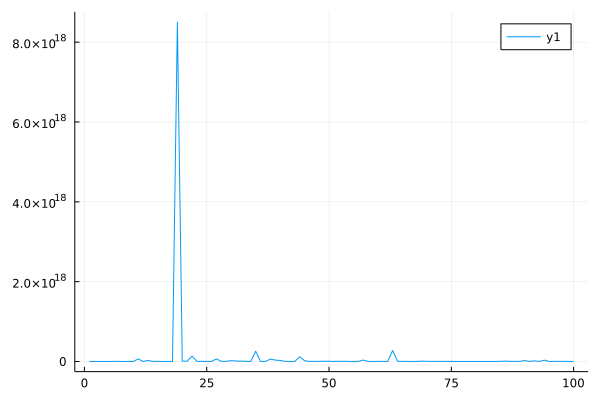

In [37]:
plot(fe_)

In [848]:
# Optimization function
function FE(model_params, p=nothing)
    fe_, h_, e_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=10);
    
    return fe_[end]
end;

In [849]:
using ForwardDiff
@time ForwardDiff.gradient(FE, model_params)

 22.832222 seconds (48.65 M allocations: 20.314 GiB, 46.77% gc time, 0.11% compilation time)


46-element Vector{Float64}:
  1277.2919859446963
 -1651.9493588302498
   956.226861122517
   -84.08540403058055
 -1430.8614112160803
  -482.7284786019352
  -183.49361813479925
 -1961.8317256531545
    12.623527448274103
  -318.2727002005424
   -21.138968055880206
  -131.2640672210167
  -164.4005882111793
     ⋮
   -48.92486897293277
   179.75412883281692
  1286.2641404525527
   -23.556192268907495
   101.29842685194457
   103.40506759317714
  2561.4199900735966
 -1325.819873667408
   198.6189251300423
   412.3911155184642
   195.14729818487234
  -602.5664219568862

In [850]:
using Optim
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-8, iterations = 50, store_trace = true, show_trace = true, show_every=1), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     5.117614e+03     2.561420e+03
 * time: 8.416175842285156e-5
     1     4.937454e+03     9.578711e+04
 * time: 229.05077600479126
     2     4.936792e+03     2.729546e+03
 * time: 820.6650919914246
     3     4.936142e+03     1.423776e+04
 * time: 934.4174380302429
     4     4.932977e+03     1.733642e+04
 * time: 1025.6808462142944
     5     4.932874e+03     2.427534e+04
 * time: 1231.0351121425629
     6     4.932643e+03     1.359281e+04
 * time: 1322.0461452007294
     7     4.932563e+03     2.493034e+04
 * time: 1413.2822661399841
     8     4.932536e+03     1.565200e+04
 * time: 1504.6861832141876
     9     4.932491e+03     2.493293e+04
 * time: 1601.6341710090637
    10     4.932489e+03     1.311506e+04
 * time: 1749.4776101112366
    11     4.932486e+03     2.494474e+04
 * time: 1819.8137040138245
    12     4.932483e+03     1.308832e+04
 * time: 1912.4124021530151
    13     4.932479e+03     2.495026e+04
 * time: 2028.4098200

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     4.932456e+03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 1.91e-09 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.46e-10 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.28e-04 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.62e-08 ≰ 0.0e+00
    |g(x)|                 = 1.88e+04 ≰ 1.0e-08

 * Work counters
    Seconds run:   4949  (vs limit Inf)
    Iterations:    50
    f(x) calls:    213
    ∇f(x) calls:   213


In [851]:
inf_params = Optim.minimizer(res)

46-element Vector{Float64}:
 -0.9372460549082184
  1.034792228017631
 -0.021777156381367804
 -1.704936681809966
 -0.3626125131423662
  1.1495009378558265
  1.6017799733833449
 -0.6330639781190283
  1.7278487517070915
 -0.1346563113710354
 -0.6734970632105903
  0.050591669440626826
  1.6748161616868529
  ⋮
 -0.8264446467269234
 -1.2713282576903089
  0.5265422397004972
  0.9518408293604569
 -2.2516857239637504
 -1.8255500509130953
  0.553535730954512
  0.6947863076979608
  0.2959312681408104
  0.35089658395100737
 -0.5539321572301343
  1.0084138032723466

In [791]:
# using GalacticOptim
# using ForwardDiff
# using Flux

# its = 100
# x0 = model_params
# f = OptimizationFunction(FE, GalacticOptim.AutoForwardDiff())
# prob = GalacticOptim.OptimizationProblem(f, x0)
# sol = solve(prob, Flux.Optimise.ADAM(), maxiters=its, cb=GalacticCallback(its))

In [852]:
fe_, h_, e_, hy_, hyu_, y_out_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=100);

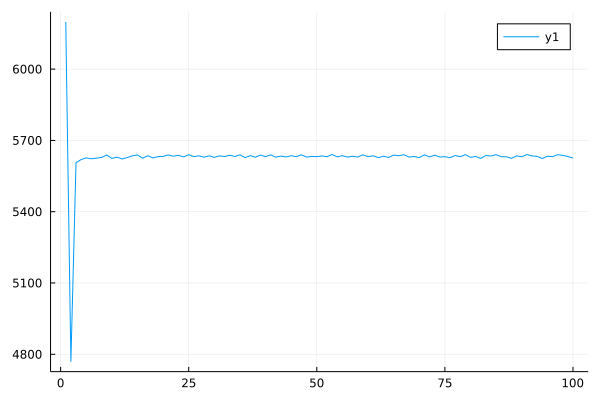

In [854]:
plot(fe_)

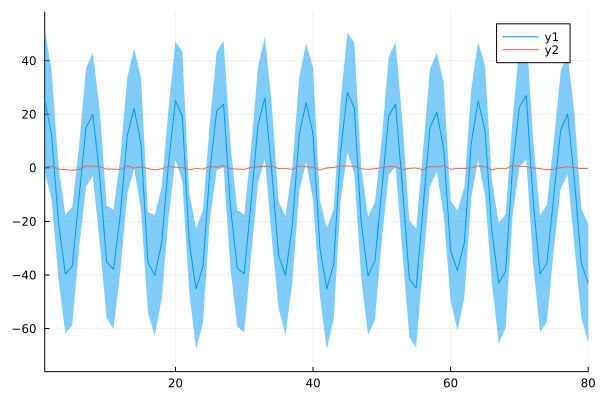

In [858]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

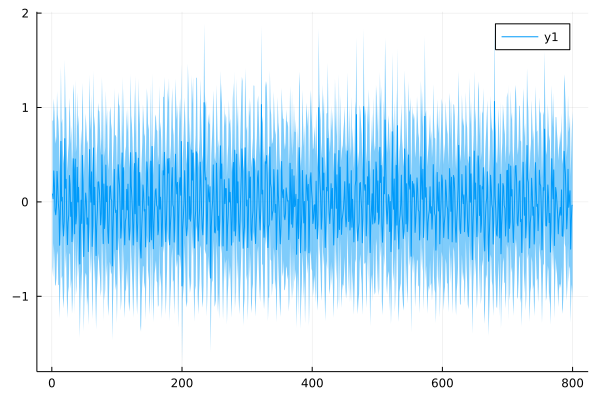

In [856]:
plot(mean.(e_), ribbon=sqrt.(cov.(e_)))

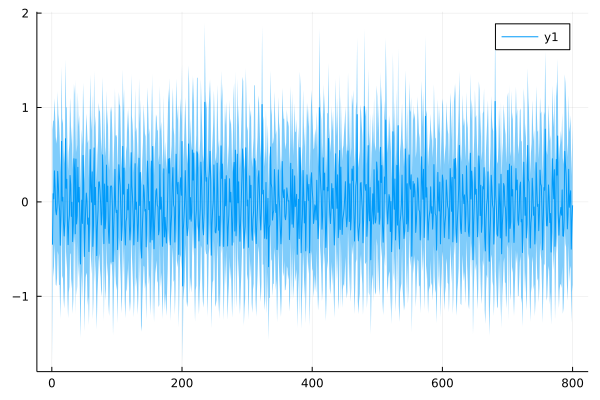

In [857]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))))